In [5]:
import pymc as pm
import numpy as np
import pandas as pd
import pytensor as pt
import seaborn as sns
import scipy.stats as stats
from scipy.special import expit as logistic
import matplotlib.pyplot as plt
import arviz as az

In [9]:
df = pd.read_csv('/content/BostonHousing.csv')
rm = df['rm']
crim = df['crim']
indus = df['indus']
medv = df['medv']
#citim fisierul si etragem coloanele de care avem nevoie dupa care le afisam
print(rm)
print(crim)
print(indus)
print("-----------------")
print(medv)

#Definim un model in pymc folosind distribuţii a priori slab informative asupra parametrilor a,b
#Se ia în considerare modelul de regresie 𝑦 ∼N(𝜇,𝜎), unde 𝜇  = a + b[0]*rm+b[1]+crim+b[2]*indus
with pm.Model() as linear_model:
    a = pm.Normal('a', mu=0, sigma=1000)
    b = pm.Normal('b', mu=0, sigma=1000, shape = 3)
    ν = pm.Exponential('ν', 1/30)
    miu = pm.Deterministic('miu',a + b[0]*rm+b[1]+crim+b[2]*indus)
    y_pred = pm.Normal('y_pred', mu=miu, sigma=1000, observed=medv)
    idata = pm.sample(2000, tune=2000, return_inferencedata=True)

pm.summary(idata)
#print(df)

0      6.575
1      6.421
2      7.185
3      6.998
4      7.147
       ...  
501    6.593
502    6.120
503    6.976
504    6.794
505    6.030
Name: rm, Length: 506, dtype: float64
0      0.00632
1      0.02731
2      0.02729
3      0.03237
4      0.06905
        ...   
501    0.06263
502    0.04527
503    0.06076
504    0.10959
505    0.04741
Name: crim, Length: 506, dtype: float64
0       2.31
1       7.07
2       7.07
3       2.18
4       2.18
       ...  
501    11.93
502    11.93
503    11.93
504    11.93
505    11.93
Name: indus, Length: 506, dtype: float64
-----------------
0      24.0
1      21.6
2      34.7
3      33.4
4      36.2
       ... 
501    22.4
502    20.6
503    23.9
504    22.0
505    11.9
Name: medv, Length: 506, dtype: float64


/usr/local/lib/python3.10/dist-packages/arviz/utils.py:184: NumbaDeprecationWarning: The 'nopython' keyword argument was not supplied to the 'numba.jit' decorator. The implicit default value for this argument is currently False, but it will be changed to True in Numba 0.59.0. See https://numba.readthedocs.io/en/stable/reference/deprecation.html#deprecation-of-object-mode-fall-back-behaviour-when-using-jit for details.
  numba_fn = numba.jit(**self.kwargs)(self.function)


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
a,0.012,746.982,-1390.368,1392.864,16.522,12.331,2052.0,2227.0,1.0
b[0],7.844,66.489,-113.439,138.398,1.316,1.095,2557.0,2263.0,1.0
b[1],-21.280,746.931,-1409.191,1393.074,15.947,11.862,2192.0,2417.0,1.0
b[2],-0.891,6.990,-14.797,11.406,0.136,0.122,2613.0,2330.0,1.0
ν,29.756,28.910,0.004,80.339,0.475,0.337,2298.0,1517.0,1.0
...,...,...,...,...,...,...,...,...,...
μ[501],19.880,50.556,-77.932,112.472,0.871,0.675,3375.0,2939.0,1.0
μ[502],16.153,45.393,-64.930,107.897,0.758,0.597,3595.0,3504.0,1.0
μ[503],22.883,66.380,-104.029,146.022,1.209,0.918,3012.0,3129.0,1.0
μ[504],21.504,58.011,-91.519,129.242,1.029,0.783,3176.0,3128.0,1.0


,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
b[0],7.844,66.489,-122.650,141.968,1.316,1.095,2557.0,2263.0,1.0
b[1],-21.280,746.931,-1520.003,1413.979,15.947,11.862,2192.0,2417.0,1.0
b[2],-0.891,6.990,-14.720,12.685,0.136,0.122,2613.0,2330.0,1.0


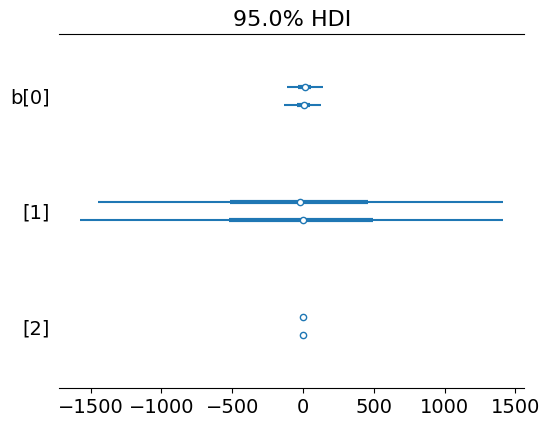

In [10]:
az.plot_forest(idata,hdi_prob=0.95,var_names=['b'])
az.summary(idata,hdi_prob=0.95,var_names=['b'])
#rm si indus au o frecventa mai mica
#Se observa ca cea mai mare influenta are crim

In [ ]:
pm.set_data({"x_shared":[[33,np.log(540)]]}, model=linear_model)
ppc = pm.sample_posterior_predictive(idata, model=linear_model)
y_ppc = ppc.posterior_predictive['y_pred'].stack(sample=("chain", "draw")).values
az.plot_posterior(y_ppc,hdi_prob=0.5)